In [1]:
import torch.nn as nn
import numpy as np
np.random.seed(0)



In [2]:
import torch.nn as nn
import torch.nn.functional as F


def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
# model parameters
params_model={
 "input_shape": (3,96,96),
 "initial_filters": 8, 
 "num_fc1": 100,
 "dropout_rate": 0.25,
 "num_classes": 2,
 }

# initialize model
cnn_model = Net(params_model)


In [4]:
import torch

path2weights="./models/weights.pt"
# load state_dict into model
cnn_model.load_state_dict(torch.load(path2weights))

In [5]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [6]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device) 

In [7]:
import time 
def deploy_model(model,dataset,device, num_classes=2,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [8]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get a list of images
        self.filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename=data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]


In [9]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [10]:
data_dir = "./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [11]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [12]:
# deploy model 
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 0.70 ms 
(44005, 2) (44005,)


### Accuracy

In [13]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.94


### Deploy on CPU

In [14]:
# deploy model on cpu
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cpu: 2.24 ms 
(44005, 2) (44005,)


# Model Inference on Test Data

In [15]:
path2csv="./data/test_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [16]:
data_dir = "./data/"
histo_test = histoCancerDataset(data_dir, data_transformer,data_type="test")
print(len(histo_test))

57458


In [17]:
y_test_out,_=deploy_model(cnn_model,histo_test, device, sanity_check=False)


y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

average inference time per image on cuda: 0.69 ms 
(57458,)


image indices: [ 2732 43567 42613 52416]
torch.Size([3, 100, 394])


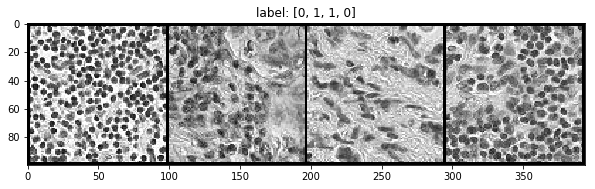

In [18]:
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)


def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))
    
grid_size=4
rnd_inds=np.random.randint(0,len(histo_test),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)

### Create Submission

In [19]:
print(y_test_out.shape)
cancer_preds = np.exp(y_test_out[:, 1])
print(cancer_preds.shape)

(57458, 2)
(57458,)


In [20]:
# get test id's from the sample_submission.csv 
path2sampleSub = "./data/"+ "sample_submission.csv"

# read sample submission
sample_df = pd.read_csv(path2sampleSub)

# get id column
ids_list = list(sample_df.id)

# convert predictions to to list
pred_list = [p for p in cancer_preds]

# create a dict of id and prediction
pred_dic = dict((key[:-4], value) for (key, value) in zip(histo_test.filenames, pred_list))    


# re-order predictions to match sample submission csv 
pred_list_sub = [pred_dic[id_] for id_ in ids_list]

# create convert to data frame
submission_df = pd.DataFrame({'id':ids_list,'label':pred_list_sub})

# Export to csv
if not os.path.exists("./submissions/"):
    os.makedirs("submissions/")
    print("submission folder created!")
    
path2submission="./submissions/submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,5.777897e-02
1,95596b92e5066c5c52466c90b69ff089b39f2737,3.418587e-03
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1.615198e-08
3,2c35657e312966e9294eac6841726ff3a748febf,9.672046e-02
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,1.990013e-02
